# Simple demo of [BiGR](https://arxiv.org/abs/2410.14672)

In [1]:


import torch
%load_ext autoreload
%autoreload 2
torch.cuda.set_device(0)

In [2]:
# clone BiGR and install environments

import os
os.environ['PYTHONPATH'] = '/env/python:/content/BiGR'
# DiT imports:
import argparse
import numpy as np
from torchvision.utils import save_image
from PIL import Image
from IPython.display import display
from torchvision.datasets.utils import download_url
from hparams import args2H
from llama.load_bigr import load_bigr
from bae.binaryae import BinaryAutoEncoder, load_pretrain
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms


/home/louis/.conda/envs/BiGR/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/louis/.conda/envs/BiGR/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
# download
def download_model(url, model_name):
    os.makedirs('pretrained_models', exist_ok=True)
    download_url(url, 'pretrained_models')
    local_path = 'pretrained_models/' + model_name
    return local_path

def find_model(args, model):
    model, size, code_dim = model.strip().split('-')
    code_dim = code_dim.split('d')[-1]
    args.model = model + '-' + size
    args.codebook_size = int(code_dim)
    url_ckpt = f"https://huggingface.co/haoosz/BiGR/resolve/main/gpt/bigr_{size}_d{code_dim}.pt"
    args.ckpt = download_model(url_ckpt, f"bigr_{size}_d{code_dim}.pt")

    if code_dim == '24':
      url_ckpt_bae = "https://huggingface.co/haoosz/BiGR/resolve/main/bae/bae_d24/binaryae_ema_1000000.th"
      args.ckpt_bae = download_model(url_ckpt_bae, "binaryae_ema_1000000.th")
    elif code_dim == '32':
      url_ckpt_bae = "https://huggingface.co/haoosz/BiGR/resolve/main/bae/bae_d32/binaryae_ema_950000.th"
      args.ckpt_bae = download_model(url_ckpt_bae, "binaryae_ema_950000.th")

def args_parser():
    # some hyperparameters
    parser = argparse.ArgumentParser()
    args = parser.parse_args(args=[])

    args.image_size = args.img_size = 256
    args.num_classes = 1000
    args.dataset = 'custom'
    args.norm_first = True
    args.cls_token_num = 1
    args.dropout_p = 0.1
    args.token_dropout_p = 0.0
    args.drop_path_rate = 0.0
    args.use_adaLN = True
    args.p_flip = True
    args.focal = 0.0
    args.alpha = -1
    args.aux = 0.0
    args.n_repeat = 1
    args.n_sample_steps = 256
    args.seq_len = 256
    args.temperature = 1.0
    args.cfg_schedule = 'constant'
    args.gumbel_schedule = 'down'
    args.infer_steps = 100
    return args


In [4]:
# model config
model = "BiGR-L-d24" #@param ["BiGR-L-d24", "BiGR-XL-d24", "BiGR-XXL-d24", "BiGR-XXL-d32"]

args = args_parser()
find_model(args, model)
args_ae = args2H(args)

# load B-AE
bae = BinaryAutoEncoder(args_ae).to(device).eval()
bae = load_pretrain(bae, args.ckpt_bae)
print(f"The code length of B-AE is set to {args_ae.codebook_size}")

# load BiGR
model = load_bigr(args, args_ae, device).eval()
print(f"GPT Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"MLP Parameters in GPT: {sum(p.numel() for p in model.denoise_mlp.parameters()):,}")


Using downloaded and verified file: pretrained_models/bigr_L_d24.pt
Using downloaded and verified file: pretrained_models/binaryae_ema_1000000.th
The code length of B-AE is set to 24
We are using adaLN!
GPT Parameters: 336,346,136
MLP Parameters in GPT: 20,255,768


You can find the full list of ImageNet classes [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

before bias:  tensor([3.3996], device='cuda:0')
torch.Size([1])
after bias:  tensor([-0.6004], device='cuda:0')
before bias:  tensor([5.0285], device='cuda:0')
torch.Size([1])
after bias:  tensor([1.0285], device='cuda:0')
before bias:  tensor([3.6912], device='cuda:0')
torch.Size([1])
after bias:  tensor([-0.3088], device='cuda:0')
before bias:  tensor([3.4492], device='cuda:0')
torch.Size([1])
after bias:  tensor([-0.5508], device='cuda:0')
before bias:  tensor([-4.4312], device='cuda:0')
torch.Size([1])
after bias:  tensor([-0.4312], device='cuda:0')
before bias:  tensor([-4.3143], device='cuda:0')
torch.Size([1])
after bias:  tensor([-8.3143], device='cuda:0')
before bias:  tensor([5.2889], device='cuda:0')
torch.Size([1])
after bias:  tensor([9.2889], device='cuda:0')
before bias:  tensor([-3.5924], device='cuda:0')
torch.Size([1])
after bias:  tensor([-7.5924], device='cuda:0')
before bias:  tensor([5.6265], device='cuda:0')
torch.Size([1])
after bias:  tensor([9.6265], device='c

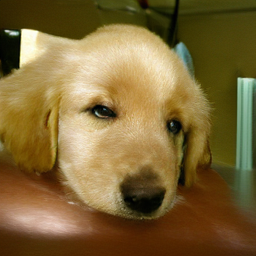

In [74]:
seed = 0 #@param {type:"raw"}
torch.manual_seed(seed)
np.random.seed(seed)

cfg_scale = 2.5 #@param {type:"slider", min:2, max:5, step:0.1}
num_sample_iter = 20 #@param {type:"slider", min:10, max:30, step:5}
gumbel_temp = 0.01 #@param {type:"slider", min:0.00, max:0.03, step:0.005}

# Labels to condition the model with (feel free to change):
class_labels = [207] #@param {type:"raw"}
latent_size = args.image_size // 16

n = len(class_labels)
y = torch.tensor(class_labels, device=device)

bs = y.shape[0]

# sample!
with torch.no_grad():
    gen_bits = model.generate_with_cfg(cond=y, max_new_tokens=latent_size ** 2, cond_padding=args.cls_token_num, num_iter=num_sample_iter,
                out_dim=bae.codebook_size, cfg_scale=cfg_scale, cfg_schedule=args.cfg_schedule,
                gumbel_temp=gumbel_temp, gumbel_schedule=args.gumbel_schedule, sample_logits=True, proj_emb=None)
samples = gen_bits.float().transpose(1,2).reshape(bs, -1, latent_size, latent_size)
samples = bae.decode(samples)
save_image(samples, 'sample.png', nrow=4, normalize=True, value_range=(0, 1))
imgs = Image.open("sample.png")
display(imgs)


In [54]:
print(gen_bits.shape)

torch.Size([1, 256, 24])


In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])
encode_imgs = transform(imgs).unsqueeze(0).to(device)  # Add batch dimension and move to device 
quant, binary, binary_det = bae.encode(encode_imgs)

samples = binary_det.float().transpose(1,2).reshape(gen_bits.shape)

In [80]:

from extended_watermark_processor import WatermarkDetector
watermark_detector = WatermarkDetector(
    vocab=[0,1],
    gamma=0.5,
    delta=4,
    seeding_scheme="selfhash",
    device="cuda",
    tokenizer=None,
    z_threshold=4.0,
    normalizers=[],
    ignore_repeated_ngrams=False,
    context_width = 2,
    message = None,
    green_list='10,01'
)
out = watermark_detector.detect(tokenized_text=binary_det.flatten().to(torch.int32))
print(out)

Green list is: {'01', '10'} 
Green list is: {'01', '10'} 
Green list is: {'01', '10'} 
Green list is: {'01', '10'} 
{'num_tokens_scored': 6143, 'num_green_tokens': 2601, 'green_fraction': 0.42340875793586197, 'z_score': -12.00602838430377, 'p_value': np.float64(1.0), 'prediction': False}


tensor([[[[-1.0190e+00, -1.2152e+00, -5.1432e-01,  ..., -1.3220e+00,
           -9.5025e-01, -1.9946e+00],
          [ 1.8151e+00, -3.3389e+00,  1.1722e-01,  ..., -2.8071e+00,
           -2.1246e+00,  1.4598e+00],
          [-3.2406e+00, -1.5997e+00, -1.1925e+00,  ..., -3.4936e+00,
           -2.5183e+00,  1.0602e+00],
          ...,
          [-7.4297e-03, -5.4926e-01, -1.0432e+00,  ..., -4.3993e+00,
            1.9148e+00,  4.5858e-01],
          [-1.5657e+00,  7.0039e-03, -1.9696e+00,  ..., -1.4257e+00,
           -3.9587e+00, -3.8608e+00],
          [-3.1199e-01,  1.4101e+00, -4.3499e-01,  ..., -3.0983e+00,
           -1.3039e+00, -3.1617e-01]],

         [[-7.9084e-01, -1.8612e+00,  1.3147e-02,  ..., -1.7841e+00,
           -3.9820e+00, -1.9701e+00],
          [-3.0339e+00, -3.6976e+00, -1.4222e+00,  ..., -2.8031e+00,
           -3.8255e+00, -3.4273e+00],
          [-1.9082e+00, -1.6357e+00, -2.2680e+00,  ..., -1.6163e+00,
           -2.6411e+00, -4.7075e+00],
          ...,
     

In [28]:
b_det_reshaped = binary_det.float().transpose(1,3).transpose(1,2)
print(b_det_reshaped.shape, gen_bits.shape)
b_det_reshaped=b_det_reshaped.reshape(gen_bits.shape).int()
print(b_det_reshaped.shape, gen_bits.shape)

enc_det = b_det_reshaped.flatten().to(torch.int32)
# gen_bits.float().transpose(1,2).reshape(bs, -1, latent_size, latent_size).int()
gen_det = gen_bits.flatten().to(torch.int32)
overlap = (enc_det == gen_det).sum().item()
print(f"Overlap between encoded and generated bits: {overlap} / {len(enc_det)}")
print(f"Overlap ratio: {overlap / len(enc_det):.2%}")

torch.Size([1, 16, 16, 24]) torch.Size([1, 256, 24])
torch.Size([1, 256, 24]) torch.Size([1, 256, 24])
Overlap between encoded and generated bits: 5937 / 6144
Overlap ratio: 96.63%


In [ ]:
# Debug: Compare sequential vs vectorized processing
# Let's test with a small sample to see where the difference comes from

# Create some test data similar to what the model produces
test_probs = torch.rand(10, 24, device=device)  # 10 positions, 24 bits each
print("Original probabilities shape:", test_probs.shape)
print("Sample values:", test_probs[:3, :5])

# Method 1: Vectorized (what works)
vectorized_result = torch.bernoulli(test_probs) * 1.0

# Method 2: Sequential with logit conversion (what produces garbage)
test_logits = torch.log((test_probs + 1e-8) / (1 - test_probs + 1e-8))
sequential_result = torch.zeros_like(test_probs)

for idx in range(test_probs.shape[1]):
    if idx == 0:
        biased_logit = test_logits[:, idx]
    else:
        delta = 0  # No bias for now
        bias = torch.where(sequential_result[:, idx-1] < 0.5, delta, -delta)
        biased_logit = test_logits[:, idx] + bias
    
    bits = torch.bernoulli(torch.sigmoid(biased_logit)) * 1.0
    sequential_result[:, idx] = bits

print("\nVectorized result shape:", vectorized_result.shape)
print("Sequential result shape:", sequential_result.shape)
print("Results are equal:", torch.allclose(vectorized_result, sequential_result, atol=1e-3))
print("\nVectorized sample:", vectorized_result[:3, :5])
print("Sequential sample:", sequential_result[:3, :5])

# Check if the issue is in the random sampling
torch.manual_seed(42)
vec_test = torch.bernoulli(test_probs[:3, :5])
torch.manual_seed(42)
seq_test = torch.zeros(3, 5)
for i in range(5):
    seq_test[:, i] = torch.bernoulli(torch.sigmoid(test_logits[:3, i]))

print("\nWith same seed:")
print("Vectorized:", vec_test)
print("Sequential:", seq_test)

In [ ]:
# Invert the transformation from line 127
# Original: samples = gen_bits.float().transpose(1,2).reshape(bs, -1, latent_size, latent_size)

print("Original gen_bits shape:", gen_bits.shape)
print("Transformed samples shape:", samples.shape)

# To invert: reshape back and transpose back
inverted_gen_bits = samples.reshape(bs, latent_size * latent_size, -1).transpose(1, 2)

print("Inverted gen_bits shape:", inverted_gen_bits.shape)
print("Shapes match:", inverted_gen_bits.shape == gen_bits.shape)
print("Values match:", torch.allclose(inverted_gen_bits, gen_bits.float(), atol=1e-6))